In [1]:

import sys
import os
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt
root="dataRaw"
path_root = "malimg_paper_dataset_imgs\\"

In [2]:
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
target_sizes = 224
batches = ImageDataGenerator().flow_from_directory(directory=path_root, target_size=(target_sizes,target_sizes), batch_size=10000)

Found 9975 images belonging to 26 classes.


In [3]:
batches.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24,
 'noMalware': 25}

In [4]:
imgs, labels = next(batches)

In [5]:
imgs.shape

(9975, 224, 224, 3)

In [6]:
labels.shape


(9975, 26)

In [7]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
    plt.show() 

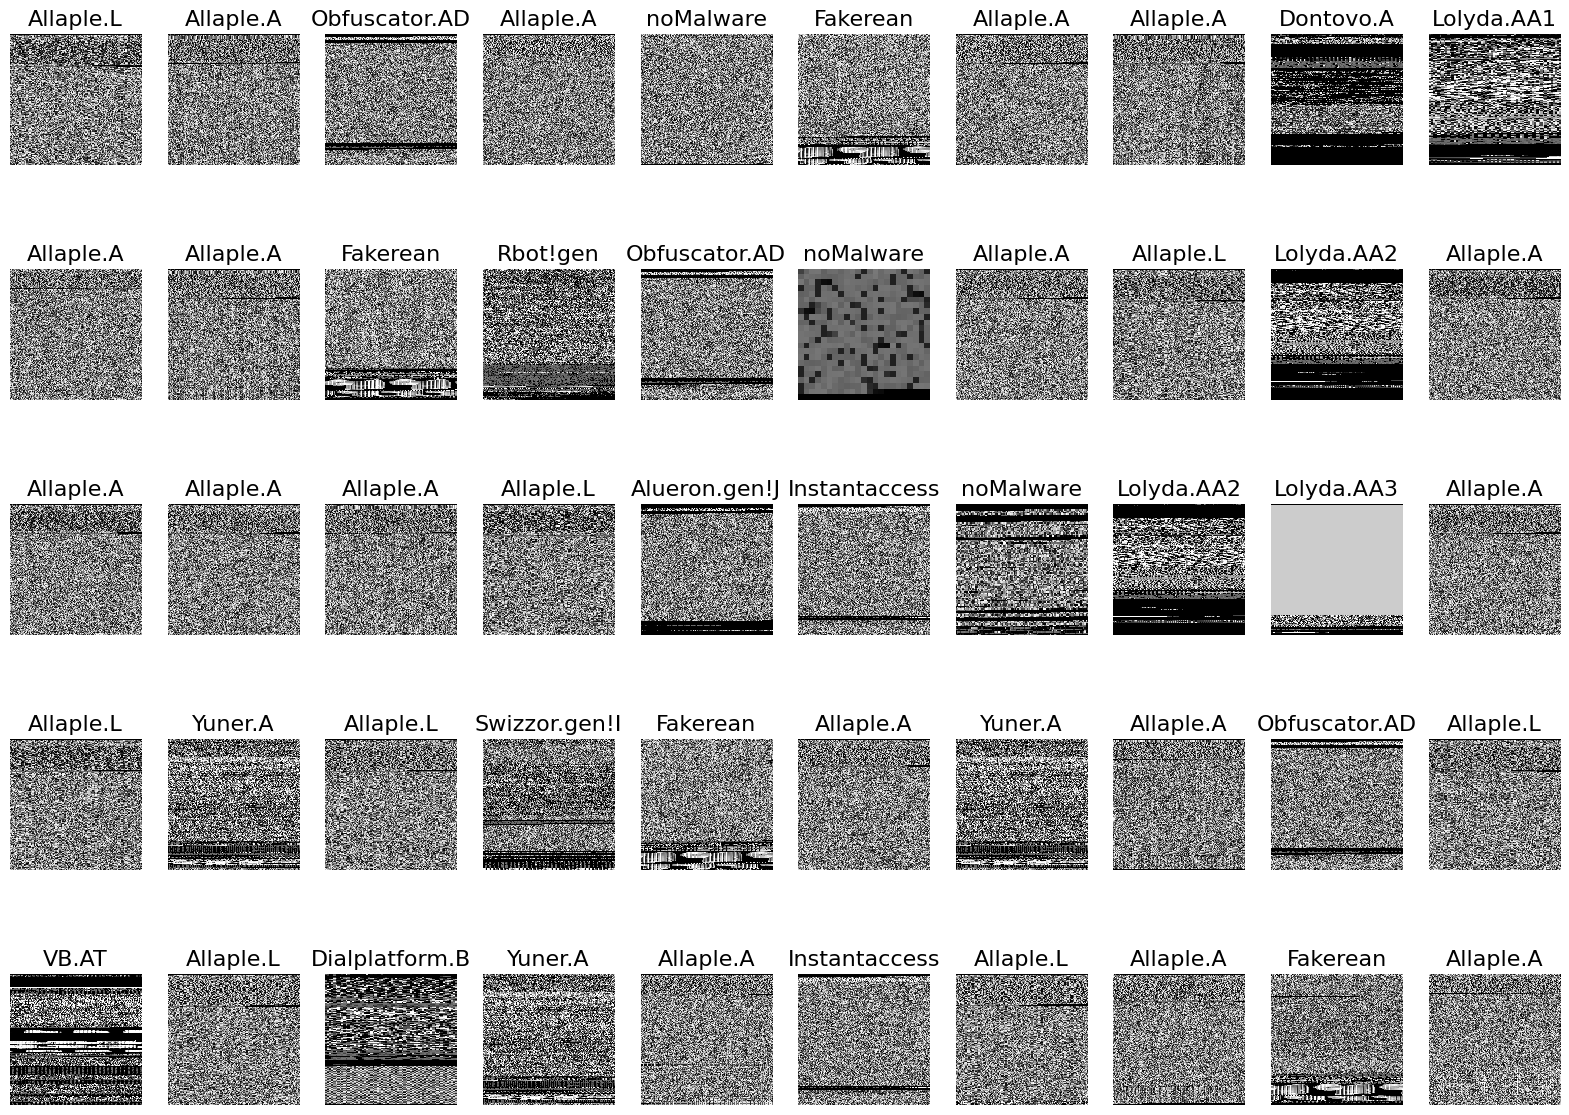

In [8]:
plots(imgs, titles = labels)

In [9]:
classes = batches.class_indices.keys()

In [10]:
perc = (sum(labels)/labels.shape[0])*100

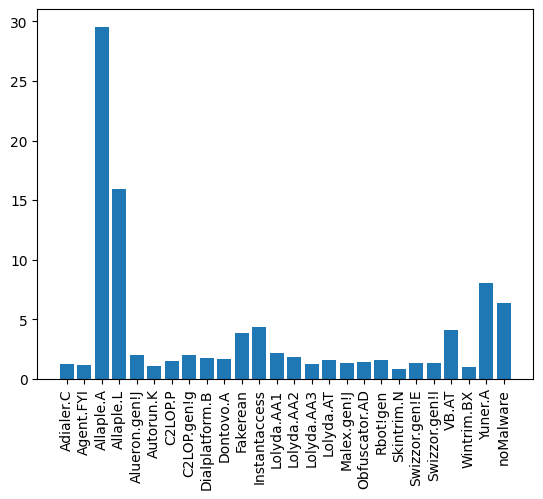

In [11]:
plt.xticks(rotation='vertical')
plt.bar(classes,perc)
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=0.3)

In [13]:
X_train.shape

(6982, 224, 224, 3)

In [14]:
X_test.shape

(2993, 224, 224, 3)

In [15]:
y_train.shape

(6982, 26)

In [16]:
y_test.shape

(2993, 26)

In [17]:
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

In [18]:
num_classes = 26

In [19]:
def malware_model():
    Malware_model = Sequential()

    Malware_model.add(Conv2D(64, padding='same', kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_sizes,target_sizes,3)))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    
    Malware_model.add(Conv2D(128, padding='same', kernel_size=(3, 3), activation='relu'))  
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    
    Malware_model.add(Conv2D(256, padding='same', kernel_size=(3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))    
    
    Malware_model.add(Flatten())
    
    Malware_model.add(Dense(256, activation='relu'))
    Malware_model.add(Dropout(0.4))
    
    Malware_model.add(Dense(num_classes,activation='softmax'))

    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

    return Malware_model

In [20]:
Malware_model = malware_model()

In [21]:
Malware_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0

In [22]:
y_train.shape

(6982, 26)

In [23]:
y_train_new = np.argmax(y_train, axis=1)


In [24]:
y_train_new

array([ 2,  5, 25, ..., 10,  2,  2], dtype=int64)

In [25]:

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train_new),y_train_new)
class_weights = dict(enumerate(class_weights))

C:\Users\Andres\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25], y=[ 2  5 25 ... 10  2  2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [26]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  #, verbose=1,callbacks =[earlystopping]


In [27]:
epochs= 10
batch_sizes = 32
history = Malware_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_sizes)
scores = Malware_model.evaluate(X_test, y_test)
print('Final CNN loss: ', scores[0])
print('Final CNN accuracy: ', scores[1])

Epoch 1/10
219/219 [==============================] - 26s 86ms/step - loss: 0.9064 - accuracy: 0.8075 - val_loss: 0.1413 - val_accuracy: 0.9589
Epoch 2/10
219/219 [==============================] - 18s 82ms/step - loss: 0.1355 - accuracy: 0.9599 - val_loss: 0.1056 - val_accuracy: 0.9632
Epoch 3/10
219/219 [==============================] - 17s 79ms/step - loss: 0.0839 - accuracy: 0.9744 - val_loss: 0.0895 - val_accuracy: 0.9756
Epoch 4/10
219/219 [==============================] - 17s 78ms/step - loss: 0.0653 - accuracy: 0.9807 - val_loss: 0.0823 - val_accuracy: 0.9793
Epoch 5/10
219/219 [==============================] - 17s 80ms/step - loss: 0.0443 - accuracy: 0.9858 - val_loss: 0.0766 - val_accuracy: 0.9816
Epoch 6/10
219/219 [==============================] - 17s 78ms/step - loss: 0.0334 - accuracy: 0.9898 - val_loss: 0.0776 - val_accuracy: 0.9826
Epoch 7/10
219/219 [==============================] - 17s 78ms/step - loss: 0.0285 - accuracy: 0.9900 - val_loss: 0.0800 - val_accuracy:

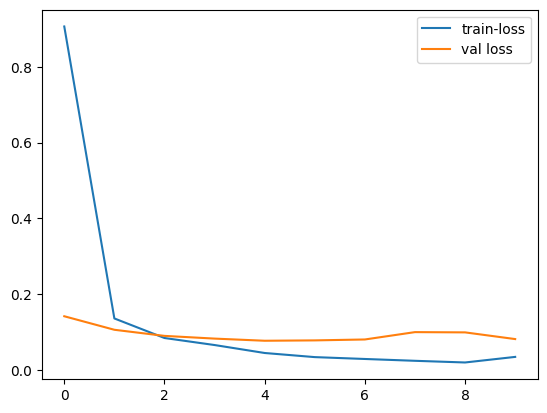

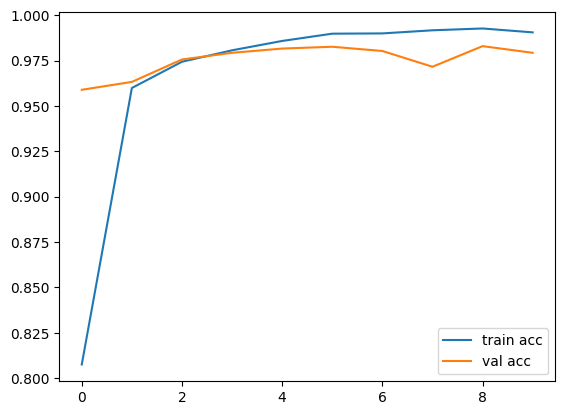

In [28]:
plt.plot(history.history['loss'],label= 'train-loss')
plt.plot(history.history['val_loss'],label= 'val loss')
plt.legend()
plt.show()


plt.plot(history.history['accuracy'],label= 'train acc')
plt.plot(history.history['val_accuracy'],label= 'val acc')
plt.legend()
plt.show()



In [29]:
import numpy as np
import pandas as pd

In [30]:
y_pred = Malware_model.predict_classes(X_test, verbose=0)

C:\Users\Andres\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [31]:
y_pred

array([11, 10,  4, ...,  2,  3, 11], dtype=int64)

In [32]:
y_test2 = np.argmax(y_test, axis=1)

In [33]:
y_test2

array([11, 10,  4, ...,  2,  3, 11], dtype=int64)

In [34]:
from sklearn import metrics
c_matrix = metrics.confusion_matrix(y_test2, y_pred)

files :  ['.ipynb_checkpoints', '0A32eTdBKayjCWhZqDOQ.bytes', '0A32eTdBKayjCWhZqDOQ.bytes.png', '0ACDbR5M3ZhBJajygTuf.bytes', '0ACDbR5M3ZhBJajygTuf.bytes.png', '9898.png', 'AllaA.png', 'autorun.png', 'obfus.png']
Processing 0A32eTdBKayjCWhZqDOQ.bytes


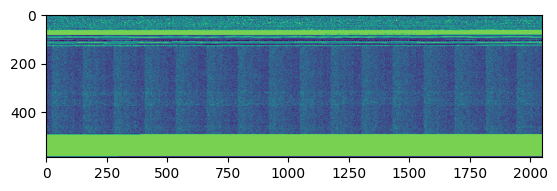

Processing 0ACDbR5M3ZhBJajygTuf.bytes


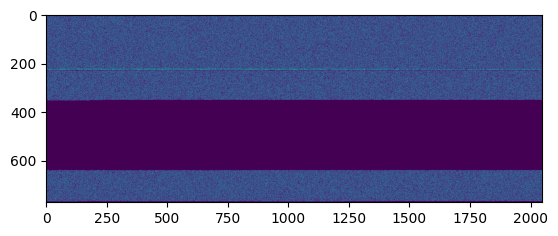

In [35]:
## This function allows us to process our hexadecimal files into png images##
def convertAndSave(array,name):
    print('Processing '+name)
    if array.shape[1]!=16: #If not hexadecimal
        assert(False)
    b=int((array.shape[0]*16)**(0.5))
    b=2**(int(log(b)/log(2))+1)
    a=int(array.shape[0]*16/b)
    array=array[:a*b//16,:]
    array=np.reshape(array,(a,b))
    im = Image.fromarray(np.uint8(array))
    im.save(root+'\\'+name+'.png', "PNG")
    return im

#Get the list of files
files=os.listdir(root)
print('files : ',files)
#We will process files one by one.
for counter, name in enumerate(files):
        #We only process .bytes files from our folder.
        if '.bytes' != name[-6:]:
            continue
        f=open(root+'/'+name)
        array=[]
        for line in f:
            xx=line.split()
            if len(xx)!=17:
                continue
            array.append([int(i,16) if i!='??' else 0 for i in xx[1:] ])
        plt.imshow(convertAndSave(np.array(array),name))
        plt.show()
        del array
        f.close()

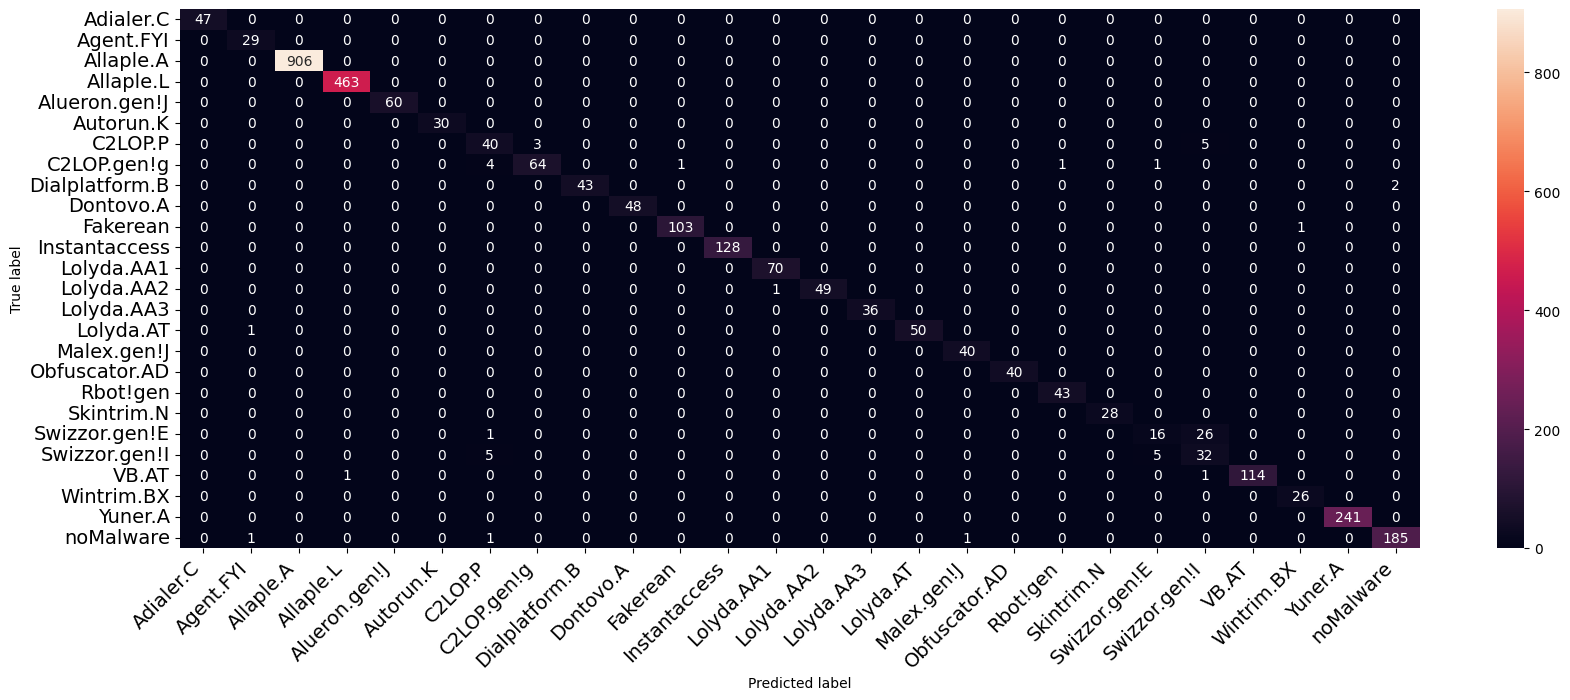

In [36]:
from sklearn import metrics
c_matrix = metrics.confusion_matrix(y_test2, y_pred)
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
import matplotlib.pyplot as plt

class_names= batches.class_indices.keys()
matrix = confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)
plt.show()

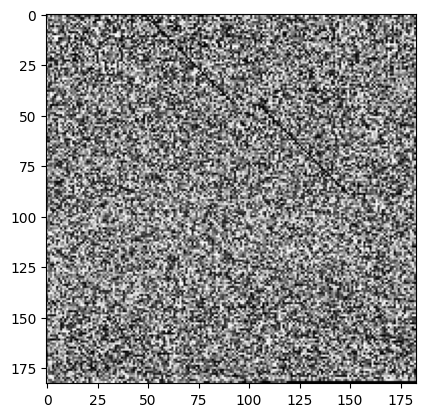

In [53]:
import cv2
img=cv2.imread(root+'\\obfus.png')
#img=cv2.imread("noMalware/10000.png")

img2 = img[:,:,::-1]
plt.imshow(img)
plt.show()

In [54]:
img=cv2.resize(img, (target_sizes,target_sizes))
img = img.astype('float')/255.0
img = np.expand_dims(img, axis=0)


In [55]:
predict_array = Malware_model.predict(img)[0]
print(predict_array)

[5.1049174e-09 2.1482946e-07 6.5087079e-06 4.0813527e-05 1.4347958e-08
 1.0803065e-09 2.4026292e-08 5.7261417e-07 3.0266833e-06 5.8184707e-08
 2.5903311e-08 1.0629521e-08 7.1469581e-06 8.3281066e-08 5.4187321e-06
 1.2844844e-06 5.9428799e-06 3.7592409e-07 2.1819901e-07 2.4450986e-10
 1.2813093e-06 7.9607673e-08 6.2239039e-08 4.3638406e-07 9.4830875e-07
 9.9992549e-01]


In [63]:
# 5 autorun.K
# 17 Obfuscator.AD
# 2 Allaple.A
# noMalware
index_predict_value= np.argmax(predict_array)
print(index_predict_value)
print("El modelo predice que es del tipo x con un %.2f"%(100*predict_array[25])+"%" )

25
El modelo predice que es del tipo x con un 99.99%


In [57]:
#script para transformar cualquier archivo en imagen
import numpy as np
from math import sqrt, ceil
import cv2
def convertAndSave(dir_file, dir_save,index):
    #Input file name (random file I found in my folder).
    input_file_name = dir_file;

    #Read the whole file to data
    with open(input_file_name, 'rb') as binary_file:        
        data = binary_file.read()

    # Data length in bytes
    data_len = len(data)

    # d is a verctor of data_len bytes
    d = np.frombuffer(data, dtype=np.uint8)

    # Assume image shape should be close to square
    sqrt_len = int(ceil(sqrt(data_len)))  # Compute square toot and round up

    # Requiered length in bytes.
    new_len = sqrt_len*sqrt_len

    # Number of bytes to pad (need to add zeros to the end of d)
    pad_len = new_len - data_len

    # Pad d with zeros at the end.
    # padded_d = np.pad(d, (0, pad_len))
    padded_d = np.hstack((d, np.zeros(pad_len, np.uint8)))

    # Reshape 1D array into 2D array with sqrt_len pad_len x sqrt_len (im is going to be a Grayscale image).
    im = np.reshape(padded_d, (sqrt_len, sqrt_len))

    # Save image
    cv2.imwrite(f"{dir_save}/{index}.png", im)



In [58]:
#convertAndSave("dataRaw/9898.png", "noMalware",10000)